# Загрузка данных и выделение целевой переменной

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [111]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('https://raw.githubusercontent.com/everstudent/python-ai-course-project/main/course_project_train.csv')

# Определим категориальные признаки сразу
cat_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Пропуски

In [112]:
# Видно, что у нас есть и пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [113]:
# Выделим  признаки с пропусками:
na_cols = ['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
df[na_cols]

,Annual Income,Years in current job,Months since last delinquent,Bankruptcies,Credit Score
0,482087.0,NaN,NaN,1.0,749.0
1,1025487.0,10+ years,NaN,0.0,737.0
2,751412.0,8 years,NaN,0.0,742.0
3,805068.0,6 years,NaN,1.0,694.0
4,776264.0,8 years,NaN,0.0,719.0
...,...,...,...,...,...
7495,402192.0,< 1 year,NaN,0.0,697.0
7496,1533984.0,1 year,43.0,0.0,7410.0
7497,1878910.0,6 years,NaN,0.0,748.0
7498,NaN,NaN,NaN,0.0,NaN


In [114]:
# Months since last delinquent - особый признак,
# т.к. для части людей его значение не имеет смысла (отсутствует просрочка)
print('Количество клиентов без просрочек', df['Months since last delinquent'].isna().sum())

# Составим на его основе новый признак - была ли просрочка или нет
df['Deliquent happened'] = df['Months since last delinquent'].isna().astype('int')
# Старый удалим
df.drop('Months since last delinquent', inplace = True, axis=1)

# Annual Income, Credit Score - заполним медианой
for f in ['Credit Score', 'Annual Income']:
  df.loc[df[f].isna(), f] = df[f].median()

# Остальные фичи заполним модой (категории или бинарные)
for f in ['Bankruptcies', 'Years in current job']:
  df.loc[df[f].isna(), f] = df[f].mode()[0]

df.info()

Количество клиентов без просрочек 4081
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   object 
 3   Tax Liens                  7500 non-null   float64
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   float64
 8   Bankruptcies               7500 non-null   float64
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly D

### Выбросы

In [115]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Deliquent happened
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,0.116933,1.187318e+07,2.898332e+05,18314.454133,1063.877333,0.281733,0.544133
std,7.567551e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,0.346904,3.192612e+07,3.178714e+05,11926.764673,1438.335832,0.449874,0.498082
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,718.000000,0.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000,1.000000
75%,1.499974e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,740.000000,1.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000,1.000000


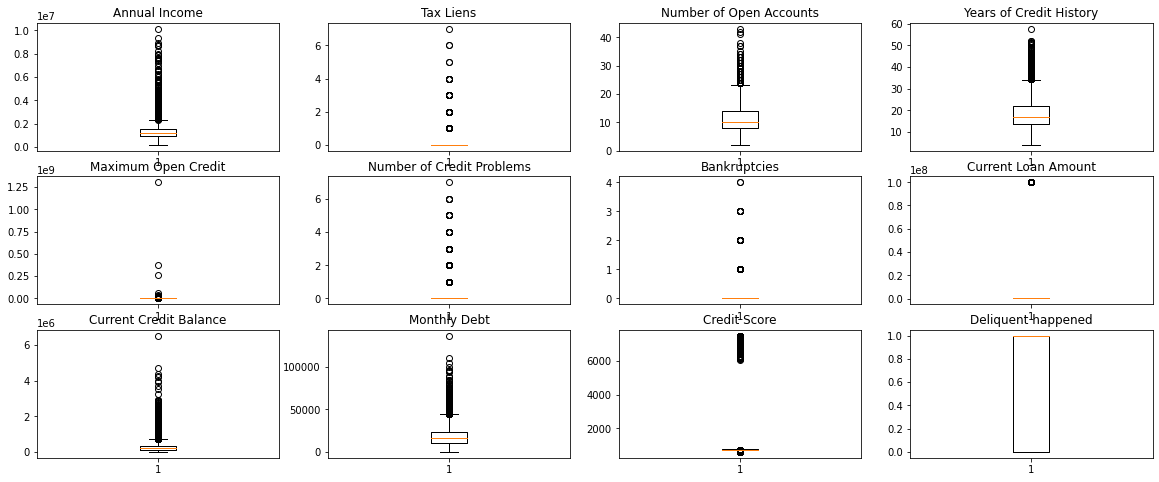

In [116]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 8))

r = 0
c = 0

for f in df.columns.drop('Credit Default').tolist():
  if f in cat_features:
    continue

  axes[c][r].boxplot(df[f])
  axes[c][r].title.set_text(f)

  r += 1
  if r >= 4:
    r = 0
    c += 1
  
plt.show()

Q99% 788942.0


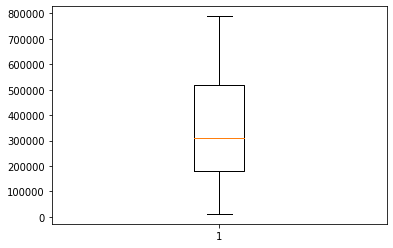

In [131]:
# Видно выброс для фичи Current Loan Amount:
print('Q99%', df['Current Loan Amount'].quantile(0.99))
df[df['Current Loan Amount'] >= df['Current Loan Amount'].quantile(0.99)]['Current Loan Amount'].count()

# Есть 870 значений типа 99999999
# Заменим их на максимум из того, набора, который меньше этого значения

critical = df['Current Loan Amount'].quantile(0.99)
df.loc[df['Current Loan Amount'] >= critical, 'Current Loan Amount'] = df[df['Current Loan Amount'] < critical]['Current Loan Amount'].max()

plt.boxplot(df['Current Loan Amount'])
plt.show()

Q90% 747.0


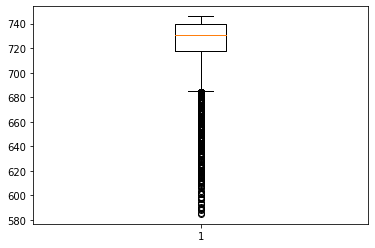

In [132]:
# Также Credit Score имеет группу выбросов
print('Q90%', df['Credit Score'].quantile(0.90))
df[df['Credit Score'] >= df['Credit Score'].quantile(0.90)]['Credit Score'].count()

# Есть 784 значения больше 90 процентили
# Заменим их на максимум из того, набора, который меньше этого значения

critical = df['Credit Score'].quantile(0.90)
df.loc[df['Credit Score'] >= critical, 'Credit Score'] = df[df['Credit Score'] < critical]['Credit Score'].max()

plt.boxplot(df['Credit Score'])
plt.show()

### Категориальные признаки

In [133]:
# Рассмотрим категориальные признаки
df[cat_features].describe()

,Home Ownership,Years in current job,Purpose,Term
count,7500,7500,7500,7500
unique,4,11,15,2
top,Home Mortgage,10+ years,debt consolidation,Short Term
freq,3637,2703,5944,5556


In [134]:
# Приведем все категориальные признаки к категориальному типу

for colname in cat_features:
    df[colname] = pd.Categorical(df[colname])

df[cat_features].dtypes

Home Ownership          category
Years in current job    category
Purpose                 category
Term                    category
dtype: object

### Анализ целевой переменной

In [135]:
# Выделяем целевую переменную и признаки
y = df['Credit Default']

# Значения таргета
y.value_counts()

# Видим всего два значения (как и ожидали) с соотношением ~ 2/1

0    5387
1    2113
Name: Credit Default, dtype: int64

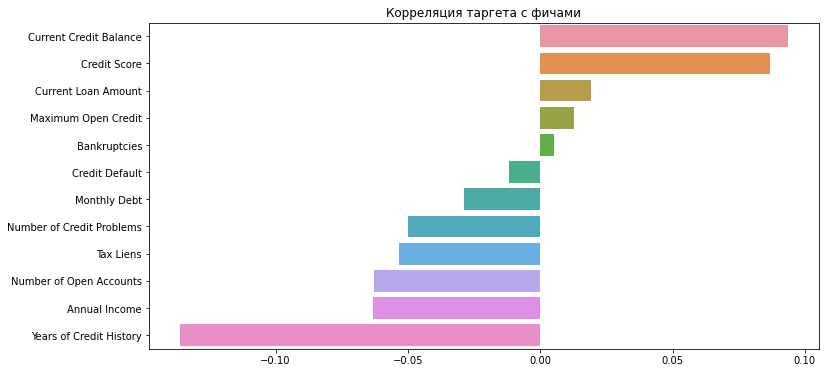

In [136]:
# Корреляция с фичами

corrs = df.corr().iloc[:-1, -1].sort_values(ascending=False) # таргет - последняя колонка в исходном датафрейме

plt.figure(figsize=(12, 6))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title('Корреляция таргета с фичами')
plt.show()

# Видно, что часть признаков имеет корреляцию с таргетом

#### Анализ Current Credit Balance в разрезе целевой переменной

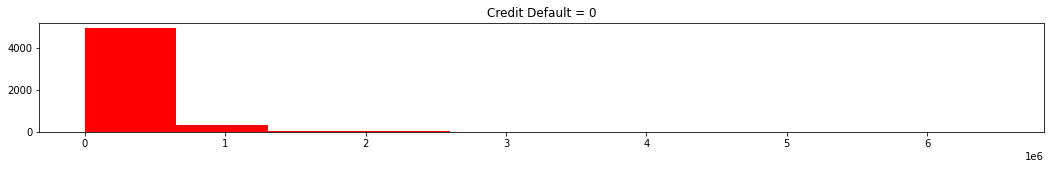

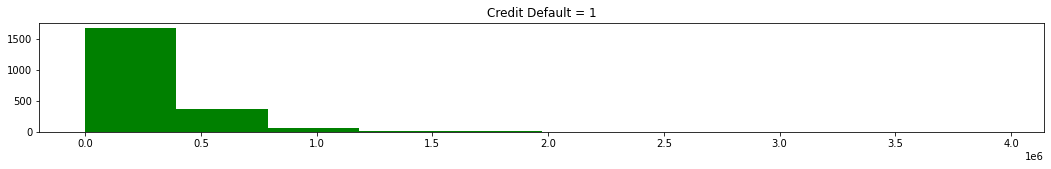

In [137]:
credit_balance = df['Current Credit Balance']

for i in [[0, 'r'], [1, 'g']]:
  plt.figure(figsize=(18, 2))
  plt.hist(credit_balance[df['Credit Default'] == i[0]], label='Credit Default = ' + str(i[0]), color=i[1])
  plt.title('Credit Default = ' + str(i[0]))
  plt.show()

**Наблюдение**

Видно, что Current Credit Balance имеет подобные распределения в обеих группах таргета.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента либо Манна-Уитни
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [138]:
# p-value сильно меньше 0.05, что говорит о том, что распределение ненормальное и необходимо использовать критерий Манна-Уитни
shapiro(credit_balance.sample(1000))

ShapiroResult(statistic=0.67896968126297, pvalue=8.369114948333537e-40)

MannwhitneyuResult(statistic=5694774.0, pvalue=0.9677722941935061)


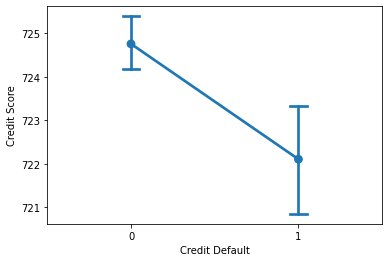

In [140]:
# Проверим гипотезу
mw = mannwhitneyu(credit_balance[df['Credit Default'] == 0], credit_balance[df['Credit Default'] == 1])
print(mw)

# проверим доверительный интервал
sns.pointplot(x='Credit Default', y='Credit Score', data=df, capsize=.1)
plt.show()

# т.к. полученное значение p > 0.05, гипотеза принимается, т.е. средние значения равны
# это значит, что значения Current Credit Balance практически не влияют на значения таргета и эту фичу можно удалить

In [141]:
# Удалим фичу из датасета
df.drop('Current Credit Balance', inplace=True, axis=1)

#### Анализ Credit Score в разрезе целевой переменной

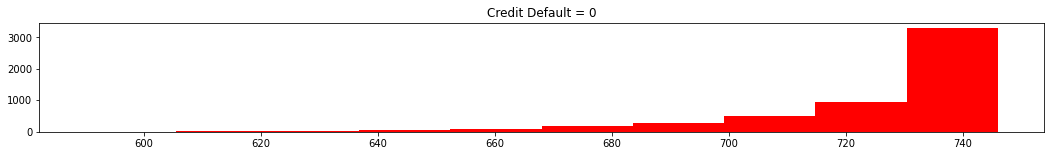

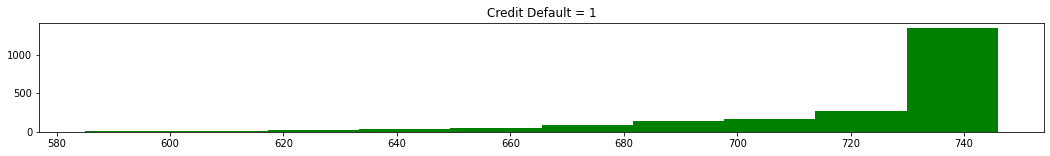

In [142]:
credit_score = df['Credit Score']

for i in [[0, 'r'], [1, 'g']]:
  plt.figure(figsize=(18, 2))
  plt.hist(credit_score[df['Credit Default'] == i[0]], label='Credit Default = ' + str(i[0]), color=i[1])
  plt.title('Credit Default = ' + str(i[0]))
  plt.show()

**Наблюдение**

Видно, что Credit Score имеет подобные распределения в обеих группах таргета.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента либо Манна-Уитни
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

In [143]:
# p-value сильно меньше 0.05, что говорит о том, что распределение ненормальное и необходимо использовать критерий Манна-Уитни
shapiro(credit_score.sample(1000))

ShapiroResult(statistic=0.7836434245109558, pvalue=2.137019342436148e-34)

MannwhitneyuResult(statistic=5683465.0, pvalue=0.9248598966067929)


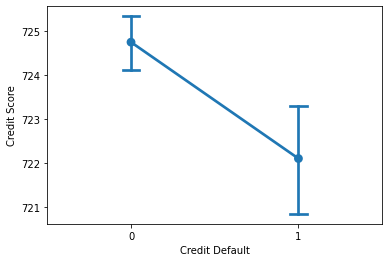

In [144]:
# Проверим гипотезу
mw = mannwhitneyu(credit_score[df['Credit Default'] == 0], credit_score[df['Credit Default'] == 1])
print(mw)

# проверим доверительный интервал
sns.pointplot(x='Credit Default', y='Credit Score', data=df, capsize=.1)
plt.show()

# т.к. полученное значение p > 0.05, гипотеза принимается, т.е. средние значения равны
# это значит, что значения Credit Score практически не влияют на значения таргета и эту фичу можно удалить

In [145]:
# Удалим фичу из датасета
df.drop('Credit Score', inplace=True, axis=1)

### Матрица корреляций

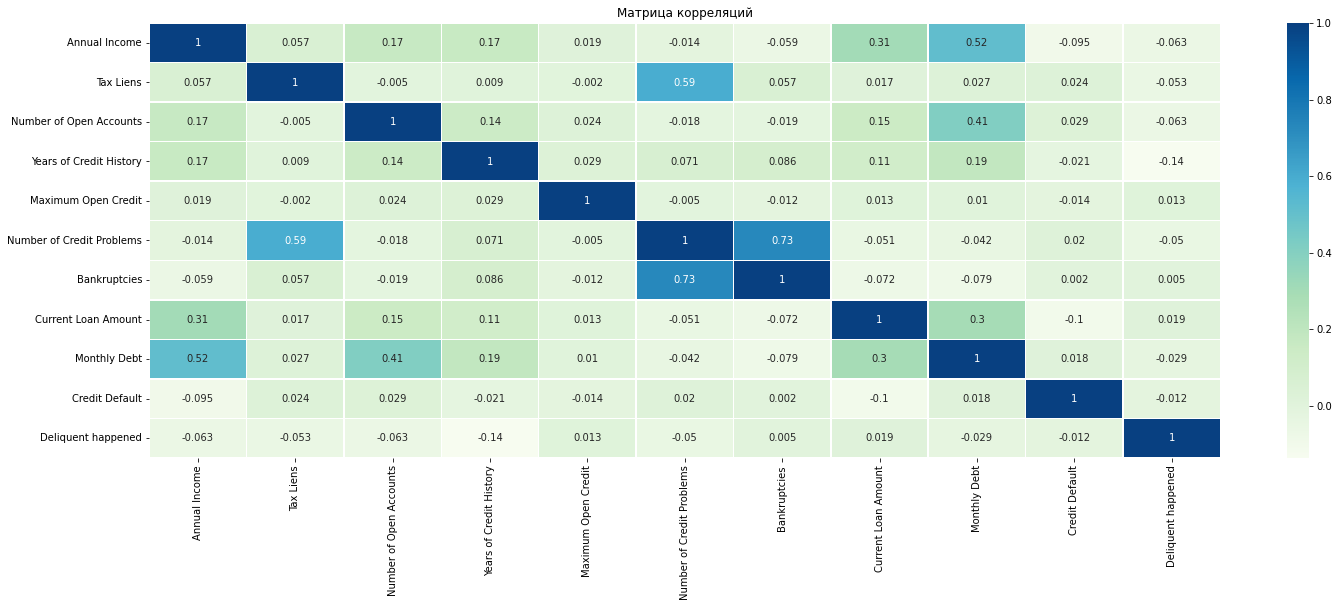

In [146]:
plt.figure(figsize = (24,8))
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Матрица корреляций')
plt.show()

Видно, что у нас есть мультиколлинеарность, т.к. признаки Bankrupcies и Number of Credit Problems, Tax Liens и Number of Credit Problems коррелируют. 

Уберем связынные фичи:

In [147]:
df.drop('Bankruptcies', inplace = True, axis=1)
df.drop('Tax Liens', inplace = True, axis=1)

### Скейлинг

In [148]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = df.columns.drop('Credit Default').tolist()

scaler = StandardScaler()
num_features = [x for x in features if x not in cat_features]
df[num_features] = scaler.fit_transform(df[num_features])

### Разделение на тестовую и обучающую выборки

In [149]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve

X = df[features]
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка

In [150]:
# Балансировка требуется, т.к. есть превалирующий класс
print(df['Credit Default'].value_counts())

def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
X_train = df_balanced.drop(columns='Credit Default')
y_train = df_balanced['Credit Default']

# Сбалансированный набор
print(df_balanced['Credit Default'].value_counts())

0    5387
1    2113
Name: Credit Default, dtype: int64
0    3771
1    2958
Name: Credit Default, dtype: int64


### Построение и выбор модели
Я выбрал модель CatBoost после сравнения с остальными по нескольким причинам:

* встроенная работа с категориальными признаками
* высокая производительность обучения

In [151]:
!pip install catboost

import catboost as catb

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Подбор параметров модели

In [152]:
# Перебираем параметры

model_catb = catb.CatBoostClassifier(class_weights=[1, 2], l2_leaf_reg = 10, silent=True, random_state=21,cat_features=cat_features)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 1000, 'max_depth': 3}
0.48761160432000406


In [153]:
# Модель с лучшими параметрами

final_model = catb.CatBoostClassifier(n_estimators=1000, l2_leaf_reg = 10, class_weights=[1, 2], max_depth=3, silent=True, random_state=21, cat_features=cat_features)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.42      0.58      3771
           1       0.56      0.94      0.70      2958

    accuracy                           0.65      6729
   macro avg       0.73      0.68      0.64      6729
weighted avg       0.75      0.65      0.63      6729

TEST

              precision    recall  f1-score   support

           0       0.89      0.38      0.54      1616
           1       0.36      0.88      0.51       634

    accuracy                           0.52      2250
   macro avg       0.63      0.63      0.52      2250
weighted avg       0.74      0.52      0.53      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               621  995
1                75  559


#### Подбор размера выборки

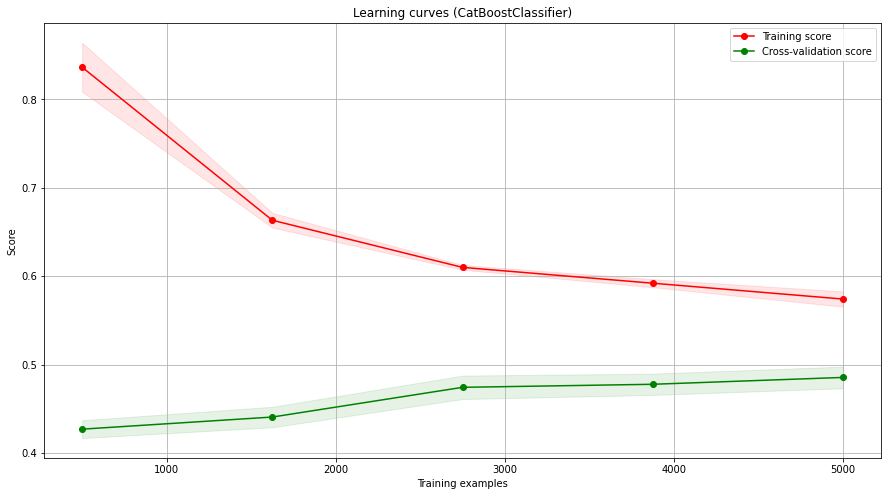

In [154]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
show_learning_curve_plot(final_model, X, y)

#### Подбор порога вероятности

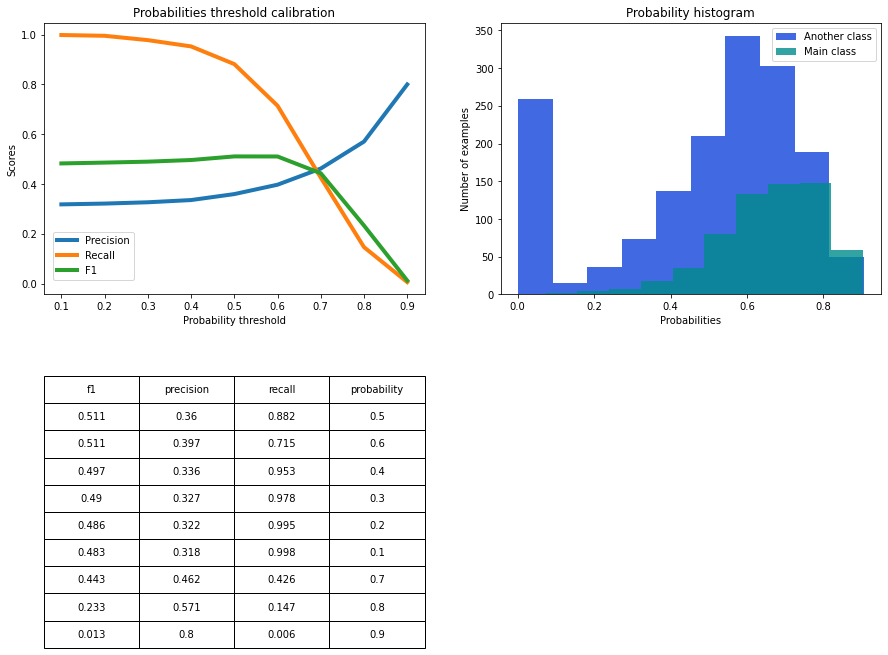

In [155]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

#### Важность признаков

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


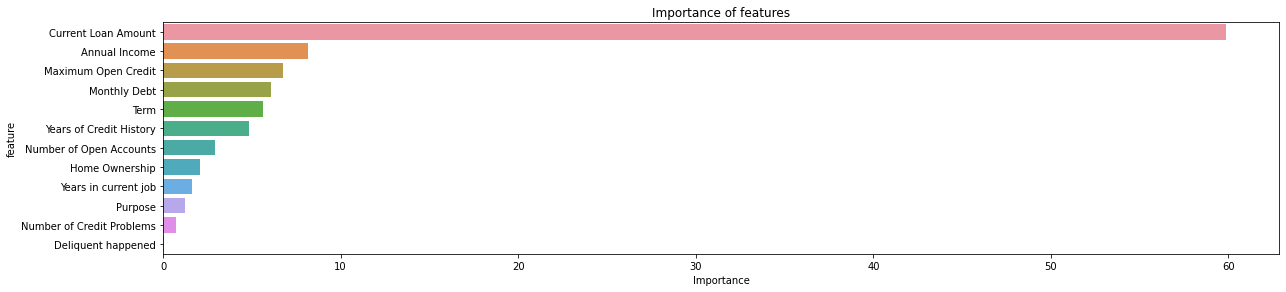

In [156]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

show_feature_importances(X_train.columns, final_model.feature_importances_)

# Прогноз на тестовой выборке

In [170]:
# Загрузка тестовых данных
df = pd.read_csv('https://raw.githubusercontent.com/everstudent/python-ai-course-project/main/course_project_test.csv')

# Заполняем пропуски и создаем новые признаки
df['Deliquent happened'] = df['Months since last delinquent'].isna().astype('int')
df.drop('Months since last delinquent', inplace = True, axis=1)
for f in ['Credit Score', 'Annual Income']:
  df.loc[df[f].isna(), f] = df[f].median()
for f in ['Bankruptcies', 'Years in current job']:
  df.loc[df[f].isna(), f] = df[f].mode()[0]

# Обрабатываем выбросы
critical = df['Current Loan Amount'].quantile(0.99)
df.loc[df['Current Loan Amount'] >= critical, 'Current Loan Amount'] = df[df['Current Loan Amount'] < critical]['Current Loan Amount'].max()

# Удаляем лишние признаки
df.drop('Current Credit Balance', inplace=True, axis=1)
df.drop('Credit Score', inplace=True, axis=1)
df.drop('Bankruptcies', inplace = True, axis=1)
df.drop('Tax Liens', inplace = True, axis=1)

# Приводим тип категориальных фич
for colname in cat_features:
    df[colname] = pd.Categorical(df[colname])

# Скейлим
num_features = [x for x in features if x not in cat_features]
df[num_features] = scaler.fit_transform(df[num_features])

X = df[features]
y_pred = final_model.predict(X)

preds = pd.DataFrame(y_pred)
preds.columns = ['Credit Default'];
preds.to_csv('DGolotiuk_predictions.csv');